In [105]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, mean_absolute_error, r2_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from datasets import load_dataset
from sklearn.preprocessing import label_binarize

In [93]:
mnist = load_dataset("mnist")
fashion_mnist = load_dataset("fashion_mnist")

**Helper Functions**

In [94]:
def preprocess_dataset(dataset):
    X = np.array([np.array(img).flatten() for img in dataset['train']['image']]) / 255.0
    y = np.array(dataset['train']['label'])
    X_test = np.array([np.array(img).flatten() for img in dataset['test']['image']]) / 255.0
    y_test = np.array(dataset['test']['label'])
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_val, y_train, y_val, X_test, y_test

In [95]:
def evaluate_model(y_true, y_pred, dataset_name, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{model_name} on {dataset_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name} on {dataset_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    return accuracy, mae, r2

In [96]:
def bagging_predict(X_train, y_train, X_val, n_estimators=10, max_samples=0.8):
    n_samples = int(max_samples * X_train.shape[0])
    models = []
    for _ in range(n_estimators):
        indices = np.random.choice(X_train.shape[0], n_samples, replace=True)
        X_sample, y_sample = X_train[indices], y_train[indices]
        tree = DecisionTreeClassifier(random_state=42)
        tree.fit(X_sample, y_sample)
        models.append(tree)
    predictions = np.array([model.predict(X_val) for model in models])
    return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)

In [97]:
def softmax(logits):
    exp_ = np.exp(logits - logits.max(axis=1, keepdims=True))
    return exp_ / exp_.sum(axis=1, keepdims=True)

def gradient_boosting_predict(
        X_train, y_train, X_val, y_val,
        n_estimators=200,
        learning_rate=0.1,
        max_depth=2,
        early_stop_rounds=20,
        random_state=42):

    rng = np.random.RandomState(random_state)
    k = np.unique(y_train).size

    Y = np.zeros((y_train.size, k), dtype=float)
    Y[np.arange(y_train.size), y_train] = 1.0

    F_train = np.zeros_like(Y)
    F_val = np.zeros((X_val.shape[0], k), dtype=float)

    best_acc = 0.0
    best_iter = -1
    models = []

    for m in range(n_estimators):
        P = softmax(F_train)
        residuals = Y - P

        stump = DecisionTreeRegressor(
            max_depth=max_depth,
            random_state=rng.randint(1e9))
        stump.fit(X_train, residuals)
        models.append(stump)

        update_train = stump.predict(X_train)
        update_val = stump.predict(X_val)

        F_train += learning_rate * update_train
        F_val += learning_rate * update_val

        if (m + 1) % 20 == 0 or m == n_estimators - 1:
            y_pred = np.argmax(softmax(F_val), axis=1)
            train_acc = accuracy_score(y_train, np.argmax(softmax(F_train), axis=1))
            val_acc = accuracy_score(y_val, y_pred)
            print(f"iter {m+1:3d}: train-acc = {train_acc:.4f}, val-acc = {val_acc:.4f}")
            if val_acc > best_acc:
                best_acc, best_iter = val_acc, m
            elif (m - best_iter) >= early_stop_rounds:
                print(f"Early stop at iter {m+1} (no val-gain in {early_stop_rounds})")
                break

    return np.argmax(softmax(F_val), axis=1)

**Pre Processing**

In [98]:
X_mnist_train, X_mnist_val, y_mnist_train, y_mnist_val, X_mnist_test, y_mnist_test = preprocess_dataset(mnist)
X_fashion_train, X_fashion_val, y_fashion_train, y_fashion_val, X_fashion_test, y_fashion_test = preprocess_dataset(fashion_mnist)

**Bagging on MNIST**


Bagging on MNIST:
Accuracy: 0.9411
R2 Score: 0.8621
MAE: 0.2303


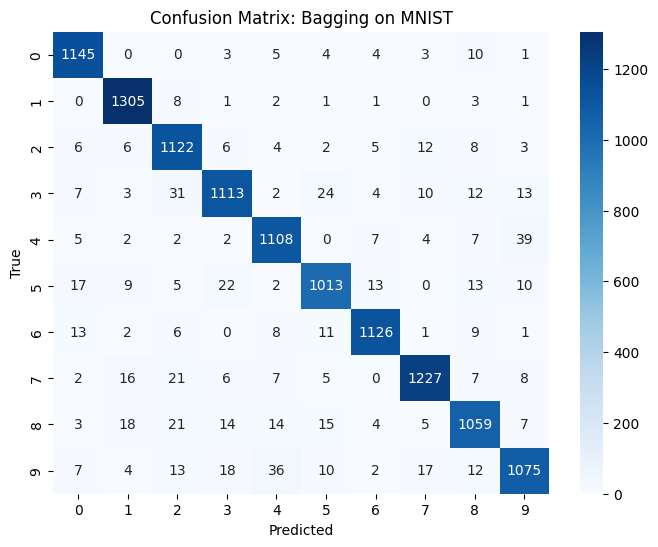

In [99]:
y_pred_bagging_mnist = bagging_predict(X_mnist_train, y_mnist_train, X_mnist_val)
metrics = evaluate_model(y_mnist_val, y_pred_bagging_mnist, "MNIST", "Bagging")

**Bagging on Fashion MNIST**


Bagging on Fashion MNIST:
Accuracy: 0.8542
R2 Score: 0.7636
MAE: 0.4710


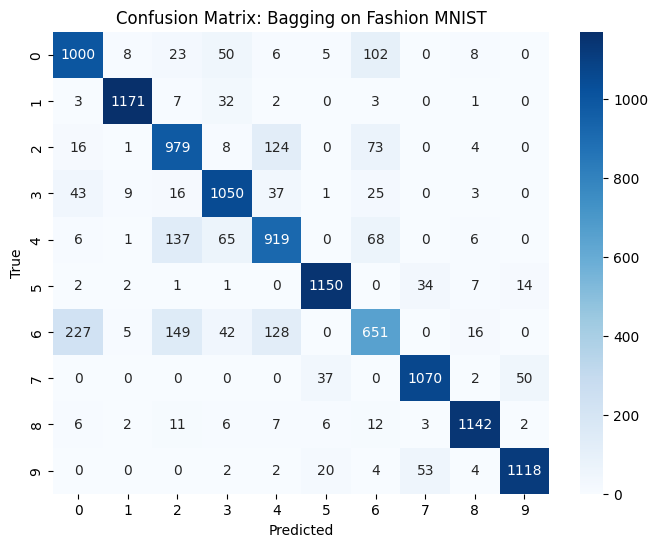

In [100]:
y_pred_bagging_fashion = bagging_predict(X_fashion_train, y_fashion_train, X_fashion_val)
metrics = evaluate_model(y_fashion_val, y_pred_bagging_fashion, "Fashion MNIST", "Bagging")

**Gradient Boosting on MNIST**

iter  20: train-acc = 0.6331, val-acc = 0.6410
iter  40: train-acc = 0.6949, val-acc = 0.6957
iter  60: train-acc = 0.7325, val-acc = 0.7304
iter  80: train-acc = 0.7476, val-acc = 0.7422
iter 100: train-acc = 0.7569, val-acc = 0.7495
iter 120: train-acc = 0.7701, val-acc = 0.7629
iter 140: train-acc = 0.7813, val-acc = 0.7765
iter 160: train-acc = 0.7936, val-acc = 0.7895
iter 180: train-acc = 0.8017, val-acc = 0.7967
iter 200: train-acc = 0.8096, val-acc = 0.8047
iter 220: train-acc = 0.8164, val-acc = 0.8117
iter 240: train-acc = 0.8222, val-acc = 0.8173
iter 260: train-acc = 0.8272, val-acc = 0.8227
iter 280: train-acc = 0.8318, val-acc = 0.8277
iter 300: train-acc = 0.8357, val-acc = 0.8317

Gradient Boosting on MNIST:
Accuracy: 0.8317
R2 Score: 0.6381
MAE: 0.6275


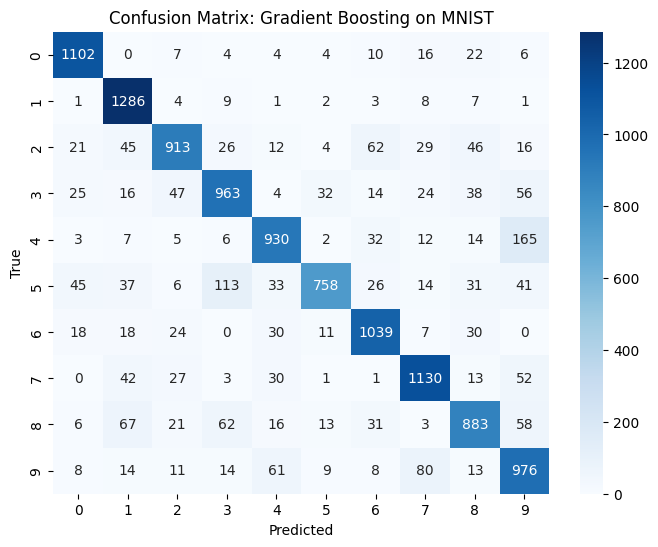

In [101]:
y_pred_mnist = gradient_boosting_predict(
    X_mnist_train, y_mnist_train, X_mnist_val, y_mnist_val,
    n_estimators=300, learning_rate=0.05, max_depth=3)
metrics = evaluate_model(y_mnist_val, y_pred_mnist, "MNIST", "Gradient Boosting")

**Gradient Boosting on Fashion MNIST**

iter  20: train-acc = 0.5815, val-acc = 0.5802
iter  40: train-acc = 0.6009, val-acc = 0.6000
iter  60: train-acc = 0.6722, val-acc = 0.6682
iter  80: train-acc = 0.7198, val-acc = 0.7131
iter 100: train-acc = 0.7332, val-acc = 0.7286
iter 120: train-acc = 0.7390, val-acc = 0.7325
iter 140: train-acc = 0.7445, val-acc = 0.7377
iter 160: train-acc = 0.7496, val-acc = 0.7438
iter 180: train-acc = 0.7588, val-acc = 0.7544
iter 200: train-acc = 0.7762, val-acc = 0.7683
iter 220: train-acc = 0.7793, val-acc = 0.7698
iter 240: train-acc = 0.7832, val-acc = 0.7737
iter 260: train-acc = 0.7860, val-acc = 0.7768
iter 280: train-acc = 0.7883, val-acc = 0.7794
iter 300: train-acc = 0.7906, val-acc = 0.7808

Gradient Boosting on Fashion MNIST:
Accuracy: 0.7808
R2 Score: 0.7015
MAE: 0.6495


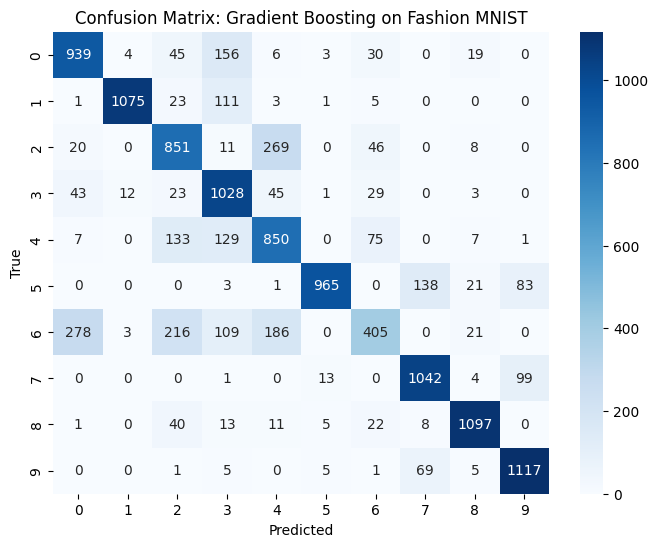

In [102]:
y_pred_fashion = gradient_boosting_predict(
    X_fashion_train, y_fashion_train, X_fashion_val, y_fashion_val,
    n_estimators=300, learning_rate=0.05, max_depth=3)
metrics = evaluate_model(y_fashion_val, y_pred_fashion, "Fashion MNIST", "Gradient Boosting")